In [74]:
import json
import os
from dotenv import load_dotenv
from tqdm import tqdm
import re
import pandas as pd
from numpy import log10
import matplotlib.pyplot as plt
from langdetect import detect

import sentence_transformers

In [75]:
load_dotenv()

True

In [76]:
results_path = os.getenv('RESULTS')

In [77]:
files = [f for f in os.listdir(results_path) if f.endswith('.jsonl') if 'summaries' in f]

In [78]:
files

['Erasmus_summaries.jsonl',
 'Leiden_summaries.jsonl',
 'Maastricht_summaries.jsonl',
 'Radboud_summaries.jsonl',
 'RUG_summaries.jsonl',
 'Tilburg_summaries.jsonl',
 'UTwente_summaries.jsonl',
 'UU_summaries.jsonl',
 'UvA_summaries.jsonl',
 'VU_summaries.jsonl']

In [79]:
# read jsonl

Summaries = []
for file in files:
    print(file)
    with open(os.path.join(results_path, file), 'r', encoding='utf-8') as f:
        Summaries.extend([json.loads(line) for line in f])

Erasmus_summaries.jsonl
Leiden_summaries.jsonl


KeyboardInterrupt: 

In [ ]:
# remove: chapter paragraph hoofdstuk paragraaf summary samenvatting 
re_replace = re.compile(r'\b(chapter|paragraph|hoofdstuk|paragraaf|summary|samenvatting)\b', re.IGNORECASE)
re_replace_m = re.compile(r'\s{2,}')
re_replace_t = re.compile(r'\t')

# initial words: english, dutch, engelse, nederlandse
re_replace_start = re.compile(r'^[\s\n\r]*(publications|references|english|dutch|engelse|nederlandse|appendix|appendices|dankwoord)\b', re.IGNORECASE)

Cleaned_Summaries = []
for summ in tqdm(Summaries):
    # use regex
    if summ['summary_dutch']:
        summ['summary_dutch'] = re_replace.sub('', summ['summary_dutch']).strip()
        summ['summary_dutch'] = re_replace_m.sub(' ', summ['summary_dutch'])
        summ['summary_dutch'] = re_replace_t.sub(' ', summ['summary_dutch'])
        summ['summary_dutch'] = re_replace_start.sub('', summ['summary_dutch']).strip()

        # remove all lines with less than <= 3 words
        summ['summary_dutch'] = '\n'.join([line for line in summ['summary_dutch'].split('\n') if len(line.split()) > 3])

    if summ['summary_english']:
        summ['summary_english'] = re_replace.sub('', summ['summary_english']).strip()
        summ['summary_english'] = re_replace_m.sub(' ', summ['summary_english'])
        summ['summary_english'] = re_replace_t.sub(' ', summ['summary_english'])
        summ['summary_english'] = re_replace_start.sub('', summ['summary_english']).strip()

        # remove all lines with less than <= 3 words
        summ['summary_english'] = '\n'.join([line for line in summ['summary_english'].split('\n') if len(line.split()) > 3])
    Cleaned_Summaries.append(summ)


100%|██████████| 15139/15139 [00:42<00:00, 356.94it/s]


In [ ]:
# Load multilingual model
model = sentence_transformers.SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
Cleaned_Summaries[10]

{'institute': 'Erasmus',
 'file': 'Erasmus_vanAndelChantal_2022-04-12_chantal_van_andel_4_h4_weg_62260e482031a.pdf',
 'summary_english': 'thus showed that individual factors, namely social dominance orientation and the perception of an inclusive work/study culture, were predictive of stereotypical ratings, whereas the context, namely social norms, was non-predictive. The study described in 3 assessed whether ethnicity-related differences in clinical grades were affected by two different types of evaluation systems. By means of a dataset with 1667 clinical grades, we have shown that an evaluation system based on multiple assessors, across multiple tests, and multiple moments, decreased ethnicity-related differences in clinical grades, as compared to a global evaluation system on the basis of a global grade on a scale between 1 (= low) to 10 (= high), given by solely one assessor. Additionally, by means of a dataset with 849 clinical grades, we showed that when supervisors were given the

In [ ]:
detect(Cleaned_Summaries[10]['summary_dutch'])

'nl'

In [ ]:
# summary english 
Paired = []
Dutch_Only = []
English_Only = []
failed=[]
for summ in tqdm(Cleaned_Summaries):
    # check if both summaries exist and have more than 25 words
    if 'summary_dutch' in summ and 'summary_english' in summ:
        dutch_len = len(summ['summary_dutch'].split()) if summ['summary_dutch'] else 0
        english_len = len(summ['summary_english'].split()) if summ['summary_english'] else 0

         # if both summaries have more than 25 words, compute similarity
         # if only one summary has more than 25 words, add to respective list

        # check if dutch summary is indeed dutch
        if dutch_len > 25:
            try:
                language = detect(summ['summary_dutch'])
            except Exception as e:
                print(f"Error detecting language for {summ['summary_dutch']}: {e}")
            if language != 'nl':
                #print(f"Detected language for Dutch summary in file {summ['file']} is not Dutch: {detect(summ['summary_dutch'])}")
                failed.append(summ['summary_dutch'])
        elif (dutch_len> 25) and (english_len > 25):
            try:
                encs= model.encode([summ['summary_dutch'], summ['summary_english']])
                sim = sentence_transformers.util.cos_sim(encs[0], encs[1])
                Paired.append({
                    'id': summ['file'],
                    'institute': summ['institute'],
                    'summary_dutch': summ['summary_dutch'],
                    'summary_english': summ['summary_english'],
                    'dutch_len': dutch_len,
                    'english_len': english_len,
                    'similarity': float(sim[0][0])
                })
            except Exception as e:
                print(f"Error processing {summ['file']}: {e}")
                failed.append(summ['file'])
        else:
            failed.append(summ['file'])
        
        if (dutch_len > 25) & (language == 'nl'):
            Dutch_Only.append({
                'id': summ['file'],
                'institute': summ['institute'],
                'summary_dutch': summ['summary_dutch'],
            })

        if english_len > 25:
            English_Only.append({
                'id': summ['file'],
                'institute': summ['institute'],
                'summary_english': summ['summary_english'],
            })

  6%|▋         | 969/15139 [00:17<04:21, 54.10it/s]


ValueError: Error detecting language for                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           S
Een ziekte wordt zeldzaam genoemd als minder dan 5 per 10.000 mensen aan de ziekte lijden en ziektes worden ultra-zeldzaam genoemd als de prevalentie nog lager is (<1 per 50.000). Het aantal mensen dat aan een specifieke zeldzame ziekte lijdt is per definitie beperkt, maar in totaal zijn er 30 tot 40 miljoen mensen in de EU met een zeldzame ziekte. Aan de klinische behoefte van patiënten met zeldzame ziektes wordt slechts beperkt te -
gemoet gekomen, omdat de interesse voor ontwikkeling van behandelingen voor deze ziektes lange tijd gering was. In de laatste decennia is de ontwikkeling van weesgenees -
middelen echter gestimuleerd door regelgeving in verschillende landen. In de 10 jaar na de invoering van regelgeving voor weesgeneesmiddelen in de EU zijn er 63 middelen toegelaten tot de markt, alhoewel voor het merendeel van de zeldzame ziekten nog steeds geen behandeling bestaat. Echter, omdat ontwikkelingskosten moeten worden terugverdiend op een relatief klein aantal patiënten zijn de prijzen van weesgenees -
middelen relatief hoog. Hierdoor worden beleidsmakers geconfronteerd met moeilijke beslissingen over het vergoeden van deze geneesmiddelen bij een vastgesteld budget; uitgaven aan één middel kunnen niet worden uitgegeven aan een andere behandeling. Health Technology Assessment (HTA) is een methodologie om op systematische wijze klinische, economische, maatschappelijke en ethische consequenties van het invoeren van een weesgeneesmiddel te onderzoeken. HTA kan door middel van deze informatie beleidsbeslissingen ondersteunen. De ziekte van Pompe is de weesziekte die centraal staat in dit proefschrift. De ziekte van Pompe is een progressieve spierziekte die behoort tot de lysosomale stapelingsziekten. De ziekte wordt veroorzaakt door een deficiëntie van het enzym zure alfa-glucosidase. Hierdoor wordt glycogeen niet goed afgebroken en accumuleert het in de lysosomen. De ziekte heeft een breed klinisch spectrum dat loopt van een snel progressieve klassiek infantiele vorm tot een minder progressieve vorm in kinderen en volwassenen. Patiën -
ten met de klassiek infantiele vorm sterven zonder specifieke behandeling doorgaans binnen het eerste levensjaar. Patiënten met een mildere vorm van de ziekte ervaren progressieve spierzwakte en ademhalingsproblemen. Het merendeel van de patiënten wordt rolstoelafhankelijk of gebruikt respiratoire ondersteuning; 15 jaar na diagnose gebruikt de helft van de patiënten een rolstoel en is ongeveer de helft van de patiën -
ten afhankelijk van ademhalingsondersteuning. In 2006 kwam enzymtherapie (ERT) beschikbaar voor de ziekte van Pompe. Er zijn verschillende uitdagingen gemoeid met het uitvoeren van een HTA studie voor deze therapie, die alle min of meer gerelateerd zijn aan het kleine aantal patiënten. Veel vraagstukken over de toepassing van HTA bij weesziekten konden worden onderzocht omdat het Erasmus MC over een rijke database beschikt met klinische data en data over overleving, kwaliteit van leven en zorggebruik, die niet alleen de periode sinds de goedkeuring van ERT beslaat, maar ook de jaren voorafgaand aan de behandeling. Bovendien was het op basis van internationale sa -
menwerking mogelijk om de overleving van Pompe patiënten te schatten. Het doel van dit proefschrift is inzicht te geven in de verschillende aspecten die de beslissingen over het vergoeden van weesgeneesmiddelen beïnvloeden, alsmede om HTA studies uit te voeren voor ERT in de ziekte van Pompe, en om bij te dragen aan het besluitvormingsproces inzake weesgeneesmiddelen.
Ziektelast vanuit verschillende perspectieven
In het eerste deel van het proefschrift wordt de ziektelast van de ziekte van Pompe van -
uit verschillende perspectieven onderzocht, waaronder een financieel en economisch perspectief, het perspectief van de patiënt en het perspectief van de mantelzorger. 2 behandelt de budgettaire impact van weesgeneesmiddelen in Nederland. 2 laat zien dat het aantal weesgeneesmiddelen en het aantal patiënten significant toenam in de periode 2006 tot 2012. In deze periode was er een substan -
tiële stijging van budgetimpact, zowel in absolute termen (van €61 miljoen naar €260 miljoen) als in het relatieve aandeel van totale farmaceutische uitgaven (van 1,1% naar 4,2%). Voor 17% van de beschikbare weesgeneesmiddelen in 2012 was de budgetim -
pact hoger dan €10 miljoen per jaar. 3 beschrijft de ziektelast van de ziekte van Pompe vanuit het perspectief van de patiënt en het maatschappelijk perspectief, in termen van kwaliteit van leven en maatschappelijke kosten bij volwassen Pompe patiënten die ondersteunende behande -
ling ontvangen. Kwaliteit van leven voor deze patiënten was 0,72; ofwel 17% lager dan voor de algemene Nederlandse bevolking. Een totaal van 40% van de patiënten moest stoppen met werken en nog eens 20% van de patiënten is minder gaan werken. Van deze patiënten gebruikte 85% mantelzorg. Jaarlijkse kosten waren €22.475 per patiënt (range €0 - €169.539). 4 toont aan dat theoretisch gerelateerde dimensies van twee generieke kwaliteit van leven meetinstrumenten (EQ-5D en SF-6D), die gebruikt werden om de kwaliteit van leven van Pompe patiënten te meten, matig tot sterk correleerden. Utilitei -
ten die werden verkregen uit beide instrumenten waren ongeveer gelijk (gemiddelde EQ-5D = 0,670; gemiddelde SF-6D = 0,699) en correleerden sterk. De SF-6D beschreef de gezondheidstoestanden voor de ziekte van Pompe beter. Het onderscheidend ver -
mogen van de EQ-5D was iets beter; SF-6D was beter in het meten van gemiddelde verandering en effectgrootte. Concluderend: de instrumenten bleken even geschikt met S
betrekking tot het meten van utiliteiten in de ziekte van Pompe, maar geen van beide presteerde uitstekend.
In 5 is de impact van de ziekte van Pompe op de mantelzorger onderzocht. Mantelzorgers (ouders, partners, andere familieleden en vrienden van de patiënt) gaven gemiddeld 17,7 uur mantelzorg per week. De helft van de mantelzorgers gaf aan men -
tale gezondheidsproblemen en problemen met dagelijkse activiteiten te ondervinden vanwege het geven van mantelzorg. Het geven van mantelzorg leidde tot fysieke klach -
ten bij 40% van de mantelzorgers. Desondanks meldden mantelzorgers voldoening te krijgen uit het geven van mantelzorg en, gemiddeld gezien, minder gelukkig zouden worden als iemand anders de zorg van hen zou overnemen. 6 presenteert een conceptueel ziektemodel voor volwassen Pompe pa -
tiënten, dat is opgezet volgens het Wilson-Cleary model. In het conceptuele model worden de relaties beschreven tussen biologische parameters, fysiologische parame -
ters, symptomen en functionele indicatoren, gezondheidspercepties en uiteindelijk gezondheidsgerelateerde kwaliteit van leven. Voor de ziekte van Pompe werden deze concepten geoperationaliseerd door enzymactiviteit, spierkracht en respiratoir functio -
neren, vermoeidheid, niveau van handicap, algemene gezondheidsperceptie, mentale en fysieke componenten schalen en utiliteiten.
Kosteneffectiviteit van ert in de ziekte van pompe
In het tweede deel van het proefschrift worden twee kosteneffectiviteitsmodellen ge -
presenteerd. 7 beschrijft de kosteneffectiviteit van ERT (inclusief ondersteu -
nende behandeling) in vergelijking tot ondersteunende behandeling (ST) bij volwassen patiënten met de ziekte van Pompe. Vanwege de onzekerheid die bestaat omtrent extrapolatie (met name van effecten), vooral als de tijdshorizon levenslang is, worden twee scenario’s gepresenteerd. In scenario 1, waarin uitsluitend de overlevingswinsten van de geobserveerde periode worden opgenomen, zijn geen winsten in overleving na de geobserveerde periode gemodelleerd, als een ongunstig scenario. In scenario 2 wor -
den wel overlevingswinsten geëxtrapoleerd na de geobserveerde periode. Voor beide scenario’s werden substantiële winsten in overleving aangetoond: verdisconteerde winst in overleving door ERT varieerde van 1,9 jaar (scenario 1) tot 5,4 jaar (scenario 2). Daarnaast was ook kwaliteit van leven significant beter voor patiënten die ERT ont -
vingen. Incrementele kosten bestonden voornamelijk uit kosten van ERT. Incrementele kosten per QALY waren €3,2 miljoen (scenario 1) en €1,8 miljoen (scenario 2).
In 8 is de kosteneffectiviteit van ERT in patiënten met de klassiek-infantiele vorm van de ziekte van Pompe onderzocht. Het kosteneffectiviteitsmodel laat zien dat de gemiddelde patiënt die ST ontving het eerste half jaar niet overleefde, terwijl de gemodelleerde levensverwachting van patiënten die met ERT behandeld werden bijna 14 jaar was. Bij een levenslange tijdshorizon werden 6,8 QALYs gewonnen door ERT. Incrementele kosten waren €7,0 miljoen, en bestonden voornamelijk (95%) uit behandelkosten. De incrementele kosten waren €1,0 miljoen per QALY en €0,5 miljoen per gewonnen levensjaar.
Gebruik van hta in beleid voor weesgeneesmiddelen
In het derde deel van het proefschrift is het gebruik van HTA in besluitvorming over weesgeneesmiddelen bestudeerd. 9 toont de variatie tussen zes Europese landen in de beslissingen om ERT in de ziekte van Pompe al dan niet te vergoeden. In de meeste landen in onze studie (Engeland, Frankrijk, Italië en België)
2 werd ERT vergoed voor alle patiënten, terwijl in Wales ERT uitsluitend werd vergoed voor klassiek-
infantiele en juveniele patiënten maar niet voor volwassen patiënten. ERT werd niet vergoed in Schotland. Meer transparantie in de besluitvorming is nodig om te bepa -
len of de verschillen in vergoeding het resultaat zijn van verschillen in de technische beoordeling van het beschikbare bewijs of in de maatschappelijke waardering van het bewijs, of beide. Transparantie kan worden verhoogd door het gebruik van een alter -
natieve aanpak, zoals Multi-Criteria Decision Making (MCDA), een methode waarmee de impact van verschillende criteria en hun relatieve gewicht expliciet gemaakt wordt. Hierdoor kan de transparantie, consistentie, geloofwaardigheid en verantwoording van vergoedingsbeslissingen verbeteren. Het lost echter het vraagstuk over de bereidheid tot betalen niet op. De toepasbaarheid van richtlijnen voor farmacoeconomisch onderzoek op weesge -
neesmiddelen en de criteria die worden gebruikt voor vergoedingsbeslissingen zijn onderzocht in 10 . Interviews en vergoedingsdossiers laten zien dat het vereiste bewijs voor de effectiviteit niet noodzakelijkerwijs lager hoeft te zijn voor weesgeneesmiddelen dan voor niet-weesgeneesmiddelen. Bovendien werden de huidige farmacoeconomische richtlijnen en de richtlijnen voor budgetimpact studies ook op weesgeneesmiddelen van toepassing geacht. In de maatschappelijke afweging van bewijs werden additionele criteria gebruikt (beperkte budgetimpact, zeldzaam -
heid van de ziekte, lage leeftijd van de populatie, identificeerbaarheid van patiënten, en afwezigheid van alternatieve behandelingen) in aanvulling op de reguliere criteria voor niet-weesgeneesmiddelen (noodzakelijkheid, effectiviteit, kosteneffectiviteit en uitvoerbaarheid). 2 Nadat onze studie was afgerond bleek dat ERT ook in Duitsland vergoed wordt S
Ten slotte beschrijft 11 verschillende perspectieven van patiënten, artsen, farmaceutische industrie, algemeen publiek, beleidsmakers en politici op het voorlo -
pige advies uit 2012 van het Zorginstituut om te stoppen met vergoeding van ERT in de ziekte van Pompe. Beschreven wordt hoe het daaropvolgende debat uiteindelijk leidde tot de beslissing om ERT wel te vergoeden (na een prijsonderhandeling over ERT) en hoe dit het beleid voor weesgeneesmiddelen in het algemeen heeft beïnvloed. In 11 worden ook verschillende aanpassingen in huidig beleid en regelgeving voor weesgeneesmiddelen besproken met betrekking tot marktexclusiviteit, prijsstel -
ling, prikkels om de ontwikkeling van weesgeneesmiddelen te stimuleren en alterna -
tieve verdienmodellen. Ten slotte worden methodologische uitdagingen voor HTA research in weesgeneesmiddelen besproken en suggesties gegeven voor toekomstig HTA onderzoek, zoals verder onderzoek naar MCDA en verdringingseffecten.
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                          
PhD Portfolio, List of publications, About the author PhD Portfolio P
PhD candidate: Tim A. Kanters
Institute: institute of Health Policy & Management, Erasmus University Rotterdam, the Netherlands
PhD period: 2008-Promotors: Prof.dr. M.P .M.H. Rutten-van Mölken Prof.dr. A.T. van der Ploeg
Copromotor: Dr. L. Hakkaart-van Roijen
Speaking skills for staff C1. Erasmus University Rotterdam. 2016.
Q-methodology . International Society for the Scientific Study of Subjectivity. 2013.
Repeated measurements. Netherlands Institute for Health Sciences. 2012.
Survival analyses. Netherlands Institute for Health Sciences. 2010.
Academic writing in English. Leiden University. 2010.
Advanced modelling methods for health economic evaluations. University York. 2009.
Prognosis research. Netherlands Institute for Health Sciences. 2009.
Pharmaceutical Pricing and Market Access, Master program Health Economics Policy & Law, Erasmus University Rotterdam. Co-coordinator & Tutor. 2014-2016.
Health Technology Assessment, Master program Health Economics Policy & Law, Erasmus University Rotterdam. Instructor computer lab. 2014-2016.: No features in text.

In [ ]:
print(Summaries[10]['summary_dutch'])

daarom, gelukkig, niet het onbedoelde gevolg dat ze daarmee stereotypes versterken. Verder liet dit onderzoek zien dat iemands voorkeur voor groep-gebaseerde hiërarchie en ongelijkheid in de maatschappij positief gerelateerd was aan negatieve stereotypes richting een studente met een Oost Aziatische achtergrond, terwijl iemands perceptie van een inclusieve werk/studeer omgeving juist positief gerelateerd was aan positieve stereotypes richting een studente zonder migratie achtergrond. Dit onderzoek liet dus zien dat, in dit geval, individuele verschillen factoren (namelijk de voorkeur voor groep-gebaseerde hiërarchie en ongelijkheid en de perceptie van een inclusieve werk/studeer omgeving) voorspellend waren voor het geven van stereotypische scores, terwijl de context (namelijk de sociale norm) deze scores niet kon voorspellen. In 3 werd onderzocht of etniciteit-gerelateerde verschillen in coschapcijfers beïnvloed worden door twee verschillende typen evaluatiesystemen. Uit een dataset v

In [ ]:
len(English_Only), len(Dutch_Only), len(Paired)

(13761, 13599, 12325)

In [ ]:
df = pd.DataFrame(Paired)

<Axes: >

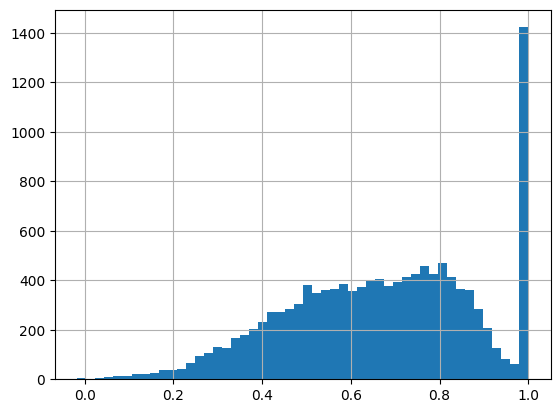

In [ ]:
df.similarity.hist(bins=50)

In [ ]:
df['rel_len'] = log10(df.dutch_len/df.english_len)

In [ ]:
df

,id,institute,summary_dutch,summary_english,dutch_len,english_len,similarity,rel_len
0,Erasmus_BosAukje_2016-11-23_161123_Bos-Aukje-C...,Erasmus,/ \n\n\n\nDe studies in dit proefschrift zijn ...,"In , co-treatment with AlgL and dornase alfa s...",688,3543,0.475314,-0.711783
1,Erasmus_PauwelsRenske_2023-05-24_proefschrift_...,Erasmus,Part IV\nAppendices\nNederlandse \nAbbreviatio...,"10 \n, discussion, future perspectives \nand g...",4407,6847,0.594004,-0.191357
2,Erasmus_GrobTim_2023-09-15_thesisgrob_-_64e210...,Erasmus,NEDERLANDSE \nAcute myeloïde leukemie (AML) is...,AND DISCUSSION\n\nAcute myeloid leukemia (AML)...,1742,7620,0.906328,-0.640907
3,Erasmus_WardehA_2001-09-19_010919_Wardeh_Alexa...,Erasmus,en conclusies \n \nRet doel van het onderzoeks...,Chapter12a \n and conclusions. \n\n and conclu...,1216,1149,0.798748,0.024614
4,Erasmus_HartmanEline_2023-01-25_digitale_versi...,Erasmus,A\nAppendices\n \nNederlandse \nList of public...,A\nAppendices\n \nNederlandse \nList of public...,2848,1440,0.752740,0.296177
...,...,...,...,...,...,...,...,...
12320,VU_SwartSanneMarijke_2021-10-05_S_M__Swart_-_t...,VU,Nederlandse \n( in Dutch)\nNederlandse ( in D...,and \nGeneral Discussion\n\n\n and General Dis...,3607,3853,0.645317,-0.028653
12321,VU_LeLargeTessaYaSung_2021-09-29_T_Y_S__Le_Lar...,VU,Appendices Nederlandse \nNEDERLANDSE \nDe mees...,Appendices English \nENGLISH \nPancreatic duct...,3164,1442,0.756455,0.341271
12322,VU_vanKollenburgBCAE_2008_complete_dissertatio...,VU,NEDERLANDSE \nNEDERLANDSE \nHet doel van het...,"7 , DISCUSSION AND \nFUTURE PERSPECTIVES \n, D...",2696,2651,0.873729,0.007310
12323,VU_NautaTD_2017_complete_dissertation.pdf,VU,Nederlandse \n\n 189 \nDe meeste wonden genez...,Discussion and future perspectives 171 \nConcl...,1009,1905,0.324532,-0.276004
